Load libraries and dataset

In [1]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
from sklearn.metrics import precision_recall_curve


Load the dataset

In [4]:
file_id = "1vgPlb7UeOMsWI4ib3nLxxqbj88t-r_XG"
url = f"https://drive.google.com/uc?id={file_id}"


In [5]:
output = "flight_data.csv"
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1vgPlb7UeOMsWI4ib3nLxxqbj88t-r_XG
From (redirected): https://drive.google.com/uc?id=1vgPlb7UeOMsWI4ib3nLxxqbj88t-r_XG&confirm=t&uuid=79becd9d-db0a-462d-98b1-34d1401667eb
To: C:\Users\tranm\Downloads\flight_data.csv
100%|██████████| 403M/403M [00:21<00:00, 18.5MB/s] 


'flight_data.csv'

In [6]:
df = pd.read_csv(output)

Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2983129 entries, 0 to 2983128
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   flight_date     object 
 1   unique_carrier  object 
 2   flight_num      float64
 3   origin_airport  object 
 4   dest_airport    object 
 5   crs_dep_time    int64  
 6   crs_arr_time    int64  
 7   cancelled       bool   
 8   weather_delay   int64  
 9   distance        int64  
 10  airport_type    object 
 11  tavg            float64
 12  tmin            float64
 13  tmax            float64
 14  prcp            float64
 15  snow            float64
 16  wspd            float64
 17  pres            float64
dtypes: bool(1), float64(8), int64(4), object(5)
memory usage: 389.8+ MB


In [8]:
df.head(100)

,flight_date,unique_carrier,flight_num,origin_airport,dest_airport,crs_dep_time,crs_arr_time,cancelled,weather_delay,distance,airport_type,tavg,tmin,tmax,prcp,snow,wspd,pres
0,2024-08-01,G4,1800.0,ABE,SRQ,730,1015,False,0,1000,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-08-03,G4,164.0,ABE,PIE,800,1039,False,0,970,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-08-03,G4,1802.0,ABE,SFB,1454,1718,False,0,882,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-08-03,G4,202.0,ABE,SFB,705,929,False,0,882,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-08-03,OH,5052.0,ABE,CLT,1208,1358,False,0,481,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2024-08-03,OO,4845.0,ACT,DFW,1032,1129,False,0,89,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2024-08-03,OO,4839.0,ACT,DFW,513,610,False,0,89,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2024-08-03,OO,4958.0,ACT,DFW,1828,1925,False,0,89,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2024-08-03,OO,4655.0,ACV,SFO,1424,1535,False,0,250,medium_airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.isnull().sum()/len(df)*100

flight_date        0.000000
unique_carrier     0.000000
flight_num         0.000034
origin_airport     0.000000
dest_airport       0.000000
crs_dep_time       0.000000
crs_arr_time       0.000000
cancelled          0.000000
weather_delay      0.000000
distance           0.000000
airport_type       0.802211
tavg              16.858507
tmin              16.858507
tmax              16.858507
prcp              17.137073
snow              31.408062
wspd              16.858507
pres              16.858507
dtype: float64

Impute 0 for the snow column

In some states, it's unlikely that there's snow. Based on that, I'll impute null values with 0.

In [10]:
df['snow'].unique()

array([nan,  0., 28., 20., 41., 38., 33., 25., 15., 13., 30.,  3.,  2.,
        5.,  1.,  8., 18., 10., 48., 43., 23.])

In [11]:
df[df['snow']==0]

,flight_date,unique_carrier,flight_num,origin_airport,dest_airport,crs_dep_time,crs_arr_time,cancelled,weather_delay,distance,airport_type,tavg,tmin,tmax,prcp,snow,wspd,pres
16,2024-08-03,UA,462.0,ABQ,IAH,735,1043,False,0,744,large_airport,26.9,21.7,35.6,0.0,0.0,8.3,1015.6
17,2024-08-03,UA,325.0,ABQ,SFO,1545,1715,False,0,896,large_airport,26.9,21.7,35.6,0.0,0.0,8.3,1015.6
18,2024-08-03,OO,4843.0,ABQ,LAX,1243,1347,False,0,677,large_airport,26.9,21.7,35.6,0.0,0.0,8.3,1015.6
19,2024-08-03,OO,5543.0,ABQ,DEN,1805,1937,False,0,349,large_airport,26.9,21.7,35.6,0.0,0.0,8.3,1015.6
20,2024-08-03,WN,284.0,ABQ,DAL,610,855,False,0,580,large_airport,26.9,21.7,35.6,0.0,0.0,8.3,1015.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983001,2024-12-31,OO,4960.0,TUL,PHX,1500,1654,False,935,0,large_airport,8.8,1.7,10.0,0.0,0.0,23.4,1018.9
2983002,2024-12-31,OO,4813.0,TUL,PHX,809,1010,False,935,0,large_airport,8.8,1.7,10.0,0.0,0.0,23.4,1018.9
2983003,2024-12-31,OO,4022.0,TUL,SLC,815,1021,False,926,0,large_airport,8.8,1.7,10.0,0.0,0.0,23.4,1018.9
2983004,2024-12-31,WN,2443.0,TUL,MDW,1410,1555,False,583,0,large_airport,8.8,1.7,10.0,0.0,0.0,23.4,1018.9


In [12]:
df['snow'] = df['snow'].fillna(0)


Impute the mode for the airport_type column

In [13]:
df['airport_type']=df['airport_type'].fillna(df['airport_type'].mode()[0])

Drop the flight_num column

In [14]:
df.drop('flight_num',axis=1,inplace=True)

Impute the median for the other missing columns

In [15]:
missing_columns=['tavg','tmin','tmax','prcp','wspd','pres']
df[missing_columns] = df[missing_columns].fillna(df[missing_columns].median())

In [16]:
df.isnull().sum()

flight_date       0
unique_carrier    0
origin_airport    0
dest_airport      0
crs_dep_time      0
crs_arr_time      0
cancelled         0
weather_delay     0
distance          0
airport_type      0
tavg              0
tmin              0
tmax              0
prcp              0
snow              0
wspd              0
pres              0
dtype: int64

Categorize time of day

In [17]:
df['dep_hour'] = (df['crs_dep_time'] // 100).astype(int)
df['arr_hour'] = (df['crs_arr_time'] // 100).astype(int)

#Categorize time of day
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['dep_period'] = df['dep_hour'].apply(time_of_day)
df['arr_period'] = df['arr_hour'].apply(time_of_day)


Calculate the duration

In [18]:
def hhmm_to_minutes(x):
    h = x // 100
    m = x % 100
    return h * 60 + m

df['dep_minutes'] = df['crs_dep_time'].apply(hhmm_to_minutes)
df['arr_minutes'] = df['crs_arr_time'].apply(hhmm_to_minutes)

df['scheduled_duration_min'] = np.where(
    df['arr_minutes'] < df['dep_minutes'],
    (1440 - df['dep_minutes']) + df['arr_minutes'],
    df['arr_minutes'] - df['dep_minutes']
)

In [19]:
df

,flight_date,unique_carrier,origin_airport,dest_airport,crs_dep_time,crs_arr_time,cancelled,weather_delay,distance,airport_type,...,snow,wspd,pres,dep_hour,arr_hour,dep_period,arr_period,dep_minutes,arr_minutes,scheduled_duration_min
0,2024-08-01,G4,ABE,SRQ,730,1015,False,0,1000,medium_airport,...,0.0,11.2,1016.7,7,10,Morning,Morning,450,615,165
1,2024-08-03,G4,ABE,PIE,800,1039,False,0,970,medium_airport,...,0.0,11.2,1016.7,8,10,Morning,Morning,480,639,159
2,2024-08-03,G4,ABE,SFB,1454,1718,False,0,882,medium_airport,...,0.0,11.2,1016.7,14,17,Afternoon,Evening,894,1038,144
3,2024-08-03,G4,ABE,SFB,705,929,False,0,882,medium_airport,...,0.0,11.2,1016.7,7,9,Morning,Morning,425,569,144
4,2024-08-03,OH,ABE,CLT,1208,1358,False,0,481,medium_airport,...,0.0,11.2,1016.7,12,13,Afternoon,Afternoon,728,838,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983124,2024-12-31,OO,SCE,ORD,1043,1200,False,528,0,large_airport,...,0.0,11.2,1016.7,10,12,Morning,Afternoon,643,720,77
2983125,2024-12-31,OO,YUM,DFW,700,1040,False,1022,0,large_airport,...,0.0,11.2,1016.7,7,10,Morning,Morning,420,640,220
2983126,2024-12-31,OO,YUM,PHX,1307,1408,False,160,0,large_airport,...,0.0,11.2,1016.7,13,14,Afternoon,Afternoon,787,848,61
2983127,2024-12-31,OO,YUM,PHX,1130,1231,False,160,0,large_airport,...,0.0,11.2,1016.7,11,12,Morning,Afternoon,690,751,61


Route frequency

In [20]:
df['route'] = df['origin_airport'] + '_' + df['dest_airport']

In [21]:
route_freq = (
    df.groupby(['flight_date', 'route'])
      .size()
      .reset_index(name='route_freq_per_day')
)

In [22]:
df = df.merge(route_freq, on=['flight_date', 'route'], how='left')

In [23]:
df

,flight_date,unique_carrier,origin_airport,dest_airport,crs_dep_time,crs_arr_time,cancelled,weather_delay,distance,airport_type,...,pres,dep_hour,arr_hour,dep_period,arr_period,dep_minutes,arr_minutes,scheduled_duration_min,route,route_freq_per_day
0,2024-08-01,G4,ABE,SRQ,730,1015,False,0,1000,medium_airport,...,1016.7,7,10,Morning,Morning,450,615,165,ABE_SRQ,1
1,2024-08-03,G4,ABE,PIE,800,1039,False,0,970,medium_airport,...,1016.7,8,10,Morning,Morning,480,639,159,ABE_PIE,1
2,2024-08-03,G4,ABE,SFB,1454,1718,False,0,882,medium_airport,...,1016.7,14,17,Afternoon,Evening,894,1038,144,ABE_SFB,3
3,2024-08-03,G4,ABE,SFB,705,929,False,0,882,medium_airport,...,1016.7,7,9,Morning,Morning,425,569,144,ABE_SFB,3
4,2024-08-03,OH,ABE,CLT,1208,1358,False,0,481,medium_airport,...,1016.7,12,13,Afternoon,Afternoon,728,838,110,ABE_CLT,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983124,2024-12-31,OO,SCE,ORD,1043,1200,False,528,0,large_airport,...,1016.7,10,12,Morning,Afternoon,643,720,77,SCE_ORD,1
2983125,2024-12-31,OO,YUM,DFW,700,1040,False,1022,0,large_airport,...,1016.7,7,10,Morning,Morning,420,640,220,YUM_DFW,1
2983126,2024-12-31,OO,YUM,PHX,1307,1408,False,160,0,large_airport,...,1016.7,13,14,Afternoon,Afternoon,787,848,61,YUM_PHX,3
2983127,2024-12-31,OO,YUM,PHX,1130,1231,False,160,0,large_airport,...,1016.7,11,12,Morning,Afternoon,690,751,61,YUM_PHX,3


Cold+wet interaction

In [24]:
df['cold_wet_index'] = df['tmin'] * df['prcp']

Long-distance + Windy

In [25]:
df['wind_distance_interaction'] = df['wspd'] * df['distance']

In [26]:
df.drop(['dep_hour', 'arr_hour', 'dep_minutes', 'arr_minutes','crs_dep_time','crs_arr_time','tmin','tmax'], axis=1, inplace=True)

2. Exploratory Data Analysis

The distribution of cancellation rates

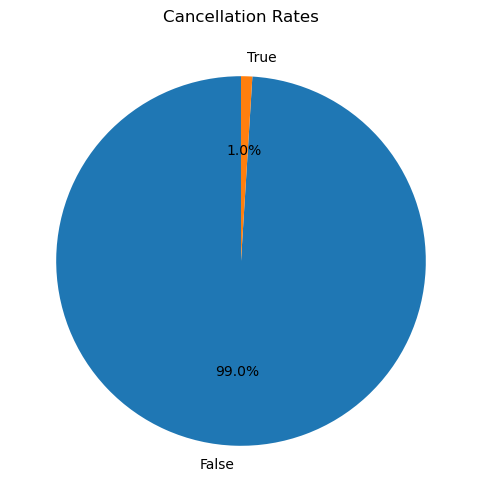

In [27]:
cancel_counts = df['cancelled'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    cancel_counts,
    labels=cancel_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Cancellation Rates')
plt.show()

The data is extremely imbalanced, so there is a need for resampling techniques.

Average Distance by Cancellation Status

C:\Users\tranm\AppData\Local\Temp\ipykernel_25008\859318911.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cancelled', y='distance', data=df, estimator='mean',palette=['#4c72b0','red'])


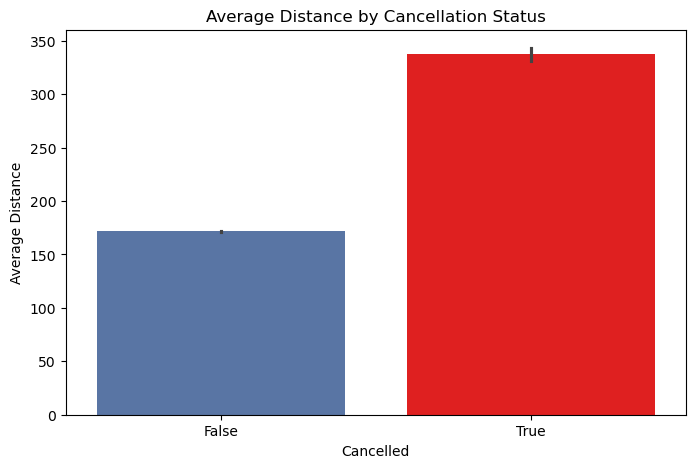

In [28]:
plt.figure(figsize=(8,5))
sns.barplot(x='cancelled', y='distance', data=df, estimator='mean',palette=['#4c72b0','red'])
plt.title('Average Distance by Cancellation Status')
plt.xlabel('Cancelled')
plt.ylabel('Average Distance')
plt.show()


The bar chart shows that cancelled flights tend to have a much higher average distance compared to non-cancelled ones.

Average Temperature by Cancellation Status

C:\Users\tranm\AppData\Local\Temp\ipykernel_25008\3349997050.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cancelled', y='tavg', data=df,palette=['#e4caad','#6b705c'])


Text(0.5, 1.0, 'Average Temperature by Cancellation Status')

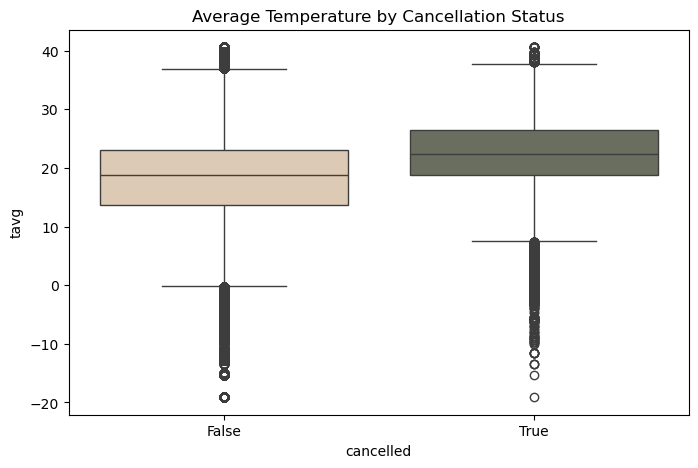

In [29]:
plt.figure(figsize=(8,5))
sns.boxplot(x='cancelled', y='tavg', data=df,palette=['#e4caad','#6b705c'])
plt.title('Average Temperature by Cancellation Status')

The boxplot shows that flights cancelled (True) generally occurred at slightly higher average temperatures compared to non-cancelled flights.
While both groups have a wide temperature range with overlapping distributions, the median temperature for cancelled flights is higher.
This suggests that warmer conditions may be modestly associated with an increased likelihood of flight cancellations.

3.Encoding and Standardizing the data

In [30]:
X= df.drop(['flight_date',	'unique_carrier',	'weather_delay','origin_airport','dest_airport'],axis=1)
y= df['cancelled']

In [31]:
X_trained, X_test, y_trained, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
numeric_features = [
     'distance',
    'tavg',  'prcp', 'snow', 'wspd', 'pres', 'scheduled_duration_min', 'route_freq_per_day', 'cold_wet_index', 'wind_distance_interaction'
]

categorical_features = [
     'airport_type','dep_period','arr_period'
]


In [33]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
   transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)


In [34]:
X_trained_preprocessed=preprocessor.fit_transform(X_trained)

In [35]:
label=LabelEncoder()
y_trained_preprocessed=label.fit_transform(y_trained)
y_test_processed=label.transform(y_test)

In [36]:
X_test_processed=preprocessor.transform(X_test)

Resample the data

In [37]:
smote_sampler = SMOTE(random_state=42)
X_trained_processed, y_trained_processed = smote_sampler.fit_resample(X_trained_preprocessed, y_trained_preprocessed)

C:\Users\tranm\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\tranm\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\tranm\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tranm\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

4.Models

Recall and the F1 score are used as the primary evaluation metrics. Recall is essential because our goal is to identify as many cancelled flights as possible, and missing a cancellation is more costly than flagging a normal flight. However, focusing on Recall alone can lead to a high number of false alarms. To maintain a practical balance, the F1 score is also emphasized. The F1 score combines precision and recall into a single measure, ensuring that the model identifies cancellations effectively while also controlling the number of incorrect positive predictions. This combination provides a more realistic assessment of model performance for a highly imbalanced dataset.

In addition, since the data is severely imbalanced, this affects which models and techniques I should choose. Below are my potential models

Logistic Regression

I chose this as my baseline because it's fast to train and easy to interpret the results. At the same time, it helps me understand if more comlex models are needed

In [38]:
lr = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=2000
)


In [39]:
lr.fit(X_trained_processed,y_trained_processed)

LogisticRegression(max_iter=2000, penalty='l1', solver='liblinear')

In [40]:
y_pred=lr.predict(X_test_processed)

<Axes: >

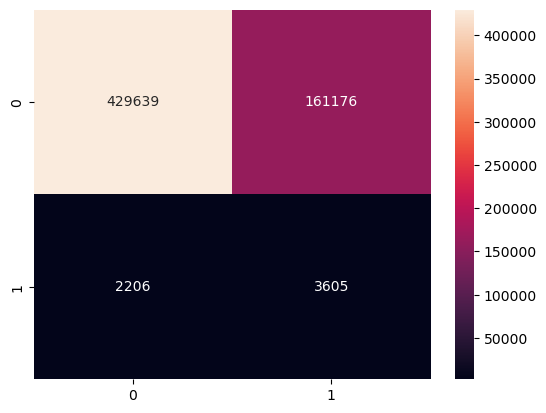

In [41]:
cm=confusion_matrix(y_test_processed,y_pred)
sns.heatmap(cm,annot=True,fmt='g')

In [42]:
accuracy=accuracy_score(y_test_processed,y_pred)
cl=classification_report(y_test_processed,y_pred)
print(f'Accuracy: {accuracy}')
print(cl)

Accuracy: 0.7261567548179262
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    590815
           1       0.02      0.62      0.04      5811

    accuracy                           0.73    596626
   macro avg       0.51      0.67      0.44    596626
weighted avg       0.99      0.73      0.83    596626



The recall looks good, but a low F-1 score means that the model aggressively predicts cancelled status for most cases. Therefore, I will choose more advanced models to catch more complex relationships.

Random Forest

In [43]:

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)



In [44]:
rf.fit(X_trained_processed, y_trained_processed)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300,
                       n_jobs=-1, random_state=42)

In [45]:
y_pred_rf = rf.predict(X_test_processed)

In [46]:
accuracy_rf=accuracy_score(y_test_processed,y_pred_rf)
cl_rf=classification_report(y_test_processed,y_pred_rf)
print(f'Accuracy: {accuracy_rf}')
print(cl_rf)

Accuracy: 0.9136293088132263
              precision    recall  f1-score   support

           0       1.00      0.92      0.95    590815
           1       0.06      0.54      0.11      5811

    accuracy                           0.91    596626
   macro avg       0.53      0.73      0.53    596626
weighted avg       0.99      0.91      0.95    596626



The Random Forest model gives a slightly higher F1 score, but it comes at the cost of a large drop in recall. This means the model has become more conservative and is missing more positive cases than before. So even though it’s performing better on correctly predicted positives overall, it still isn’t capturing the deeper, non-linear patterns in the data. We’ll need a more expressive model to better learn those complex relationships.

Importance Analysis

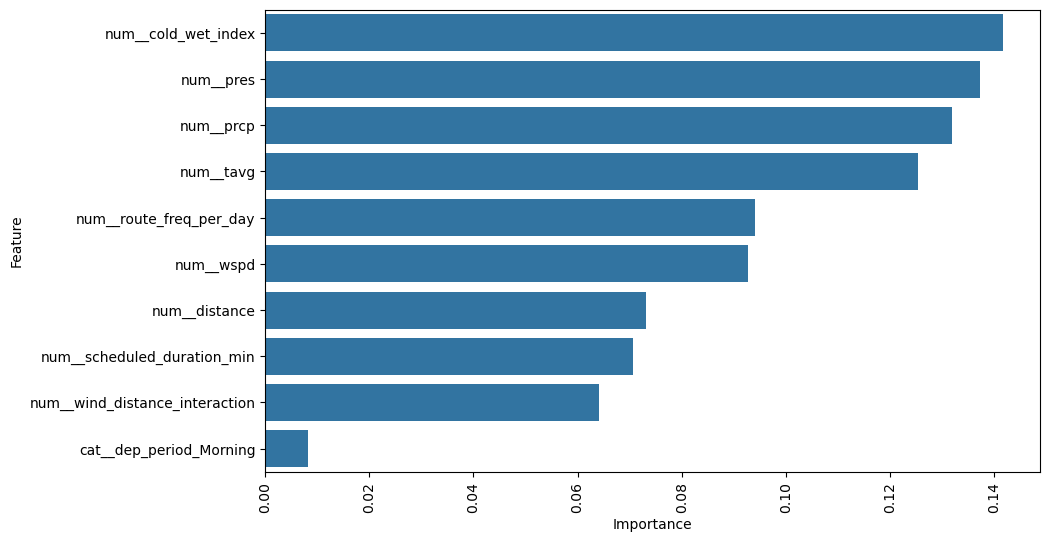

In [47]:
importance=rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_table=pd.DataFrame({'Feature': feature_names,'Importance':importance})
feature_table=feature_table.sort_values(by='Importance',ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(y='Feature',x='Importance',data=feature_table[:10])
plt.xticks(rotation=90)
plt.show()

The Random Forest’s feature importance ranking shows that weather-related variables carry most of the predictive signal for delays. Factors such as cold and wet conditions, atmospheric pressure, precipitation, and average temperature dominate the model, suggesting that adverse weather plays a major role in shaping cancellation risk. Operational factors like route frequency, wind speed, distance, and scheduled duration also contribute meaningfully, indicating that both environmental and logistical conditions influence performance.

XGBoost

XGBoost with Pre-Resampled Data - Using pre-resampled data is better because XGBoost already handles imbalance internally, and resampling often distorts the data and leads to overfitting.

In [ ]:
ratio = (len(y_trained_preprocessed) - sum(y_trained_preprocessed)) / sum(y_trained_preprocessed)

In [ ]:


xgb_ws = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=ratio,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss"
)


In [55]:
xgb_ws.fit(X_trained_preprocessed, y_trained_preprocessed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [56]:
xgb_ws_pred = xgb_ws.predict(X_test_processed)

<Axes: >

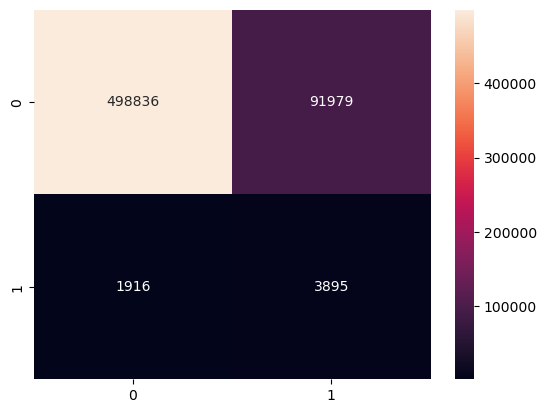

In [57]:
cm_xgb_ws=confusion_matrix(y_test_processed,xgb_ws_pred)
sns.heatmap(cm_xgb_ws,annot=True,fmt='g')

In [58]:
accuracy_xgb_ws=accuracy_score(y_test_processed,xgb_ws_pred)
cl_xgb_ws=classification_report(y_test_processed,xgb_ws_pred)
print(f'Accuracy: {accuracy_xgb_ws}')
print(cl_xgb_ws)


Accuracy: 0.8426233519826491
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    590815
           1       0.04      0.67      0.08      5811

    accuracy                           0.84    596626
   macro avg       0.52      0.76      0.50    596626
weighted avg       0.99      0.84      0.91    596626



The model captures a large portion of actual cancellations, but its very low precision shows that it also predicts many cancellations that do not happen. This means it is good at detecting true cancellations but still over-flags flights, which is a common trade-off when the cancellation class is extremely rare.

Change the threshold

Choose the most balanced threshold

In [59]:
y_proba=xgb_ws.predict_proba(X_test_processed)[:,1]

In [60]:
prec, rec, thr = precision_recall_curve(y_test, y_proba)

In [61]:
f1 = 2 * (prec * rec) / (prec + rec)
best_idx = np.argmax(f1)
best_threshold = thr[best_idx]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Precision: {prec[best_idx]:.3f}, Recall: {rec[best_idx]:.3f}, F1: {f1[best_idx]:.3f}")


Best Threshold: 0.906
Precision: 0.363, Recall: 0.260, F1: 0.303


In [62]:
y_pred = (y_proba > 0.906).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99    590815
        True       0.36      0.26      0.30      5811

    accuracy                           0.99    596626
   macro avg       0.68      0.63      0.65    596626
weighted avg       0.99      0.99      0.99    596626



Lowering the threshold made the model more willing to predict cancellations, which increased precision for the cancellation class but reduced recall. This means the model is now better at avoiding false cancellation alarms but misses more actual cancellations. The trade-off shows that threshold tuning directly controls how conservative or aggressive the model is when flagging true cancellations.

5. Final Conclusion

   
After completing my analysis, I found that the dataset is highly imbalanced, with cancellations representing only a very small portion of all flights. Because of this imbalance, traditional accuracy metrics are misleading. Even though models like Random Forest achieved over 90% accuracy, the recall for the cancelled class remained low, meaning the models missed a large majority of the flights that were actually cancelled.

Given this limitation, I cannot rely on these models as direct “cancellation predictors.” Instead, the most realistic and useful application is to use them as risk-scoring tools. Rather than making a strict cancelled/not-cancelled prediction, the models can assign a probability score that helps identify flights with elevated disruption risk. This approach provides operational value by highlighting flights that need closer monitoring, earlier staff allocation, or proactive operational planning.

To further improve model performance, future work should focus on handling class imbalance through methods such as class weighting, oversampling techniques (like SMOTE), or cost-sensitive learning. These adjustments can help the models better capture rare cancellation events.

In summary, while the current models are not suitable for automated cancellation predictions, they are effective for risk assessment and can support more proactive decision-making when combined with operational expertise.